In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import log_loss,classification_report,confusion_matrix

from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings('ignore')

C:\Users\Danish\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [5]:
df = pd.read_csv(r"Z:\DS DATA\feature_train.csv")

In [8]:
Target = df["is_duplicate"]
df.drop(columns=["id","qid1","qid2","question1",'question2',"is_duplicate"],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   freq_qid1         404290 non-null  int64  
 1   freq_qid2         404290 non-null  int64  
 2   q1_total_words    404290 non-null  int64  
 3   q2_total_words    404290 non-null  int64  
 4   q1_n_words        404290 non-null  int64  
 5   q2_n_words        404290 non-null  int64  
 6   q1_union_q2       404290 non-null  int64  
 7   q1_q2_word_share  404290 non-null  int64  
 8   total_words       404290 non-null  int64  
 9   word_share        404290 non-null  float64
 10  intr_by_union     404290 non-null  float64
 11  fq1_pls_fq2       404290 non-null  int64  
 12  fq1_diff_fq2      404290 non-null  int64  
 13  cwc_min           404290 non-null  float64
 14  cwc_max           404290 non-null  float64
 15  csc_min           404290 non-null  float64
 16  csc_max           40

In [9]:
print("-"*15,"Distribution of points","-"*15)
print("Class 0: {}        Class 1: {}".format(
    Target.value_counts()[0]/len(Target),Target.value_counts()[1]/len(Target)))


--------------- Distribution of points ---------------
Class 0: 0.630802146973707        Class 1: 0.369197853026293


In [10]:
# x_train, x_test, y_train, y_test = train_test_split(df,Target,stratify=Target,test_size=0.3)

X_train,X_test, y_train, y_test = train_test_split(
    df, Target, stratify=Target, test_size=0.3)

In [11]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283003, 27)
Number of data points in test data : (121287, 27)


In [12]:
print("-"*15,"Distribution of points y_train","-"*15)
print("Class 0: {}%        Class 1: {}%".format(
    y_train.value_counts()[0]/len(y_train),y_train.value_counts()[1]/len(y_train)))
print("-"*15,"Distribution of points y_test","-"*15)
print("Class 0: {}%        Class 1: {}%".format(
    y_test.value_counts()[0]/len(y_test),y_test.value_counts()[1]/len(y_test)))


--------------- Distribution of points y_train ---------------
Class 0: 0.6308025003268517%        Class 1: 0.36919749967314835%
--------------- Distribution of points y_test ---------------
Class 0: 0.6308013224830361%        Class 1: 0.3691986775169639%


In [2]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h1>Building a random model to calculate the worest-case of log_loss</h1>

0.8873848863070161


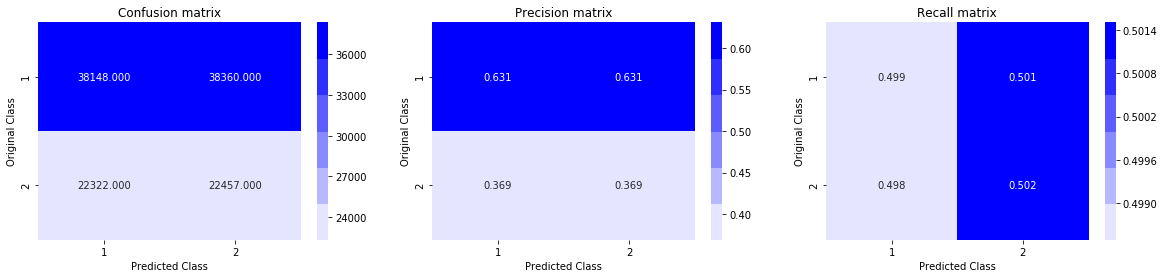

In [ ]:
# this is line creates an ndarray of shape 3000x2 
pred_y = np.zeros((len(y_test),2))

for i in range(len(y_test)):
#     this is line will create a array 1X2 
#     with random distribution populated in it
    rand_probs = np.random.rand(1,2)
    pred_y[i]= ((rand_probs/sum(sum(rand_probs)))[0])
print(log_loss(y_test,pred_y))


predicted_y =np.argmax(pred_y, axis=1)
plot_confusion_matrix(y_test,predicted_y)


<h2> 1 <i><u>Using basing and Advanced feature test of Different Models</u></i></h2>

<h2> 1.1 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.41425371726447646
For values of alpha =  0.0001 The log loss is: 0.43093099801297075
For values of alpha =  0.001 The log loss is: 0.4630435946798659
For values of alpha =  0.01 The log loss is: 0.4422453122041781
For values of alpha =  0.1 The log loss is: 0.44892239849041055
For values of alpha =  1 The log loss is: 0.48410448143506074
For values of alpha =  10 The log loss is: 0.5289160868103715


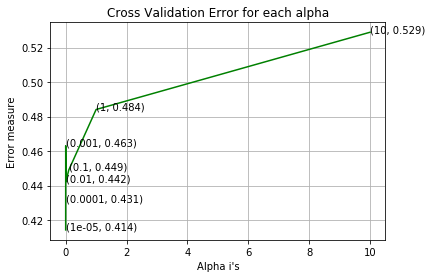

For values of best alpha =  1e-05 The train log loss is: 0.41278315944023697
For values of best alpha =  1e-05 The test log loss is: 0.41425371726447646
Total number of data points : 121287


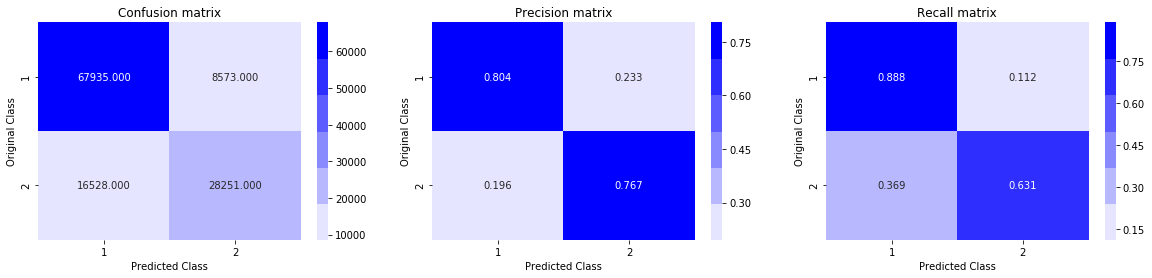

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 1.2 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4201873129379323
For values of alpha =  0.0001 The log loss is: 0.427563655733895
For values of alpha =  0.001 The log loss is: 0.4611318710372264
For values of alpha =  0.01 The log loss is: 0.48052939293748465
For values of alpha =  0.1 The log loss is: 0.4903264558768826
For values of alpha =  1 The log loss is: 0.5589619452938275
For values of alpha =  10 The log loss is: 0.5729100093110495


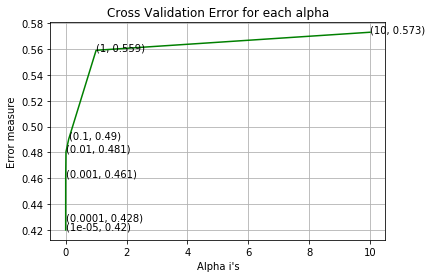

For values of best alpha =  1e-05 The train log loss is: 0.41811455592222885
For values of best alpha =  1e-05 The test log loss is: 0.4201873129379323
Total number of data points : 121287


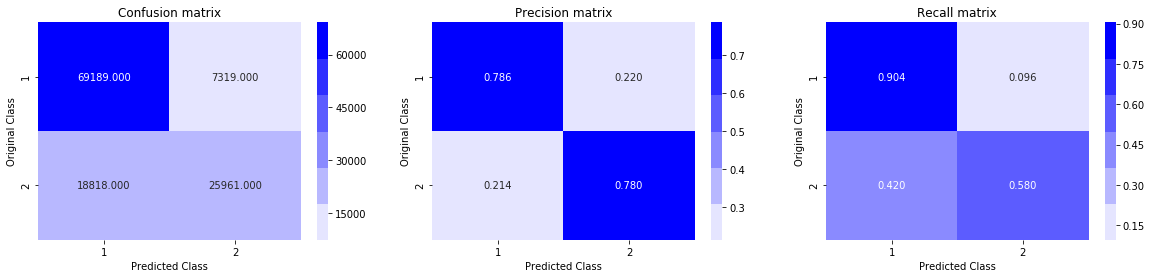

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 1.3 XGBOOST </h2>

In [48]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.68492	valid-logloss:0.68492
[10]	train-logloss:0.61583	valid-logloss:0.61583
[20]	train-logloss:0.56464	valid-logloss:0.56474
[30]	train-logloss:0.52587	valid-logloss:0.52601
[40]	train-logloss:0.49670	valid-logloss:0.49683
[50]	train-logloss:0.47360	valid-logloss:0.47372
[60]	train-logloss:0.45537	valid-logloss:0.45548
[70]	train-logloss:0.44046	valid-logloss:0.44052
[80]	train-logloss:0.42839	valid-logloss:0.42836
[90]	train-logloss:0.41864	valid-logloss:0.41853
[100]	train-logloss:0.41072	valid-logloss:0.41057
[110]	train-logloss:0.40424	valid-logloss:0.40406
[120]	train-logloss:0.39885	valid-logloss:0.39864
[130]	train-logloss:0.39425	valid-logloss:0.39399
[140]	train-logloss:0.39043	valid-logloss:0.39015
[150]	train-logloss:0.38713	valid-logloss:0.38681
[160]	train-logloss:0.38437	valid-logloss:0.38403
[170]	train-logloss:0.38173	valid-logloss:0.38140
[180]	train-logloss:0.37963	valid-logloss:0.37926
[190]	train-logloss:0.37749	valid-logloss:0.37712
[200]	train

<h2>2 Computing TFIDF vectors data set and combining both Data sets </h2>

In [8]:
df = pd.read_csv(r"Z:\DS DATA\feature_train.csv")
print(df.shape)
print(list(df.columns))

(404290, 33)
['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate', 'freq_qid1', 'freq_qid2', 'q1_total_words', 'q2_total_words', 'q1_n_words', 'q2_n_words', 'q1_union_q2', 'q1_q2_word_share', 'total_words', 'word_share', 'intr_by_union', 'fq1_pls_fq2', 'fq1_diff_fq2', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'fw_com', 'lw_com', 'abs_diff', 'ratio', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio', 'partial_ratio']


In [9]:
df.dropna(axis=0,inplace=True)
Target = df["is_duplicate"]
df.drop(columns=['id','qid1','qid2','is_duplicate'],axis=1,inplace=True)
print(df.shape)
df.head(2)

(404210, 29)


,question1,question2,freq_qid1,freq_qid2,q1_total_words,q2_total_words,q1_n_words,q2_n_words,q1_union_q2,q1_q2_word_share,...,ctc_min,ctc_max,fw_com,lw_com,abs_diff,ratio,token_set_ratio,token_sort_ratio,fuzz_ratio,partial_ratio
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,1,1,14,12,12,11,13,10,...,0.916659,0.785709,1.0,0.0,2.0,13.0,100,93,93,100
1,what is the story of kohinoor koh-i-noor dia...,what would happen if the indian government sto...,4,1,8,13,8,12,16,4,...,0.624992,0.384612,1.0,0.0,5.0,10.5,86,63,66,75


In [11]:
# Initilizing TFIDF VECTORIZEER FOR QUESTION 1 AND QUESTION 2
Tfidf_Vect_question1 = TfidfVectorizer()
Tfidf_Vect_question2 = TfidfVectorizer()


# Creating features of question
Tfidf_q1 = Tfidf_Vect_question1.fit_transform(df["question1"].values.astype("U")) 
Tfidf_q2 = Tfidf_Vect_question2.fit_transform(df["question2"].values.astype("U")) 

In [12]:
print("Total no of features created from quesiton1 are:  ",len(Tfidf_Vect_question1.get_feature_names()))
print("Total no of features created from quesiton2 are:  ",len(Tfidf_Vect_question2.get_feature_names()))

Total no of features created from quesiton1 are:   62092
Total no of features created from quesiton2 are:   57137


In [13]:
from scipy.sparse import hstack

# scipy.sparse.hstack(blocks, format=None, dtype=None)
    # Stack sparse matrices horizontally (column wise)

# Parameters
    # blocks
    # sequence of sparse matrices with compatible shapes

# formatstr
    # sparse format of the result (e.g., “csr”) by default an appropriate
    # sparse matrix format is returned. This choice is subject to change.

# dtypedtype, optional
    # The data-type of the output matrix. If not given, the dtype is determined from that of


# from scipy.sparse import hstack,coo_matrix
# A=coo_matrix([[1,2],[3,5]])
# B=coo_matrix([[0],[4]])
# d=hstack([A,B]).toarray()
# d
# ----------------output--------------
# array([[1, 2, 0],
#        [3, 5, 4]], dtype=int32)
question1_question2 = hstack((Tfidf_q1,Tfidf_q2))

In [54]:
df.drop(columns=['question1','question2'],inplace=True)

In [55]:
# combining features created before with the tfidf features of the both question
df_features_tfidf_features = hstack((df,question1_question2),format="csr",dtype="float64")

# shape of the data set
print(df_features_tfidf_features.get_shape()) # also shape can be used to and works same 

(404210, 119256)


In [56]:
# x_train, x_test, y_train, y_test = train_test_split(df,Target,stratify=Target,test_size=0.3)

X_train,X_test, y_train, y_test = train_test_split(
    df_features_tfidf_features, Target, stratify=Target, test_size=0.3)
print(len(Target))
df_features_tfidf_features.shape

404210


(404210, 119256)

In [57]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

print("-"*15,"Distribution of points y_train","-"*15)
print("Class 0: {}%        Class 1: {}%".format(
    y_train.value_counts()[0]/len(y_train),y_train.value_counts()[1]/len(y_train)))
print("-"*15,"Distribution of points y_test","-"*15)
print("Class 0: {}%        Class 1: {}%".format(
    y_test.value_counts()[0]/len(y_test),y_test.value_counts()[1]/len(y_test)))


Number of data points in train data : (282947, 119256)
Number of data points in test data : (121263, 119256)
--------------- Distribution of points y_train ---------------
Class 0: 0.6307329641240232%        Class 1: 0.36926703587597676%
--------------- Distribution of points y_test ---------------
Class 0: 0.6307364983548156%        Class 1: 0.36926350164518446%


<h2> 2.1 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.3788023191861889
For values of alpha =  0.0001 The log loss is: 0.3830383497365892
For values of alpha =  0.001 The log loss is: 0.4221438666484024
For values of alpha =  0.01 The log loss is: 0.4512439529791137
For values of alpha =  0.1 The log loss is: 0.46397898058003445
For values of alpha =  1 The log loss is: 0.488753520438745
For values of alpha =  10 The log loss is: 0.5320830098667123


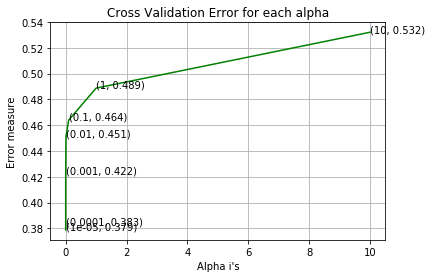

For values of best alpha =  1e-05 The train log loss is: 0.37122875229216046
For values of best alpha =  1e-05 The test log loss is: 0.3788023191861889
Total number of data points : 121263


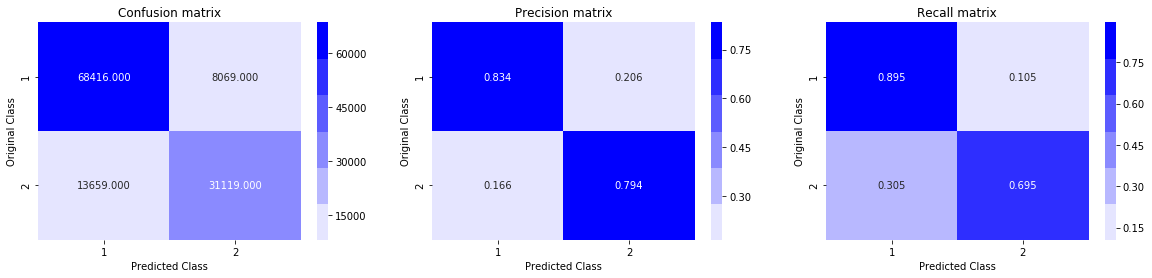

In [36]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 2.2 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.42897818434569335
For values of alpha =  0.0001 The log loss is: 0.4340572497163949
For values of alpha =  0.001 The log loss is: 0.44280733399922517
For values of alpha =  0.01 The log loss is: 0.45668449339046296
For values of alpha =  0.1 The log loss is: 0.48415610410196935
For values of alpha =  1 The log loss is: 0.5468157759054142
For values of alpha =  10 The log loss is: 0.6585625400698283


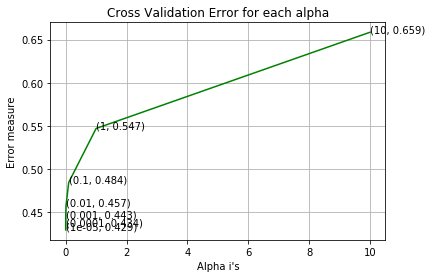

For values of best alpha =  1e-05 The train log loss is: 0.423871555319787
For values of best alpha =  1e-05 The test log loss is: 0.42897818434569335
Total number of data points : 121263


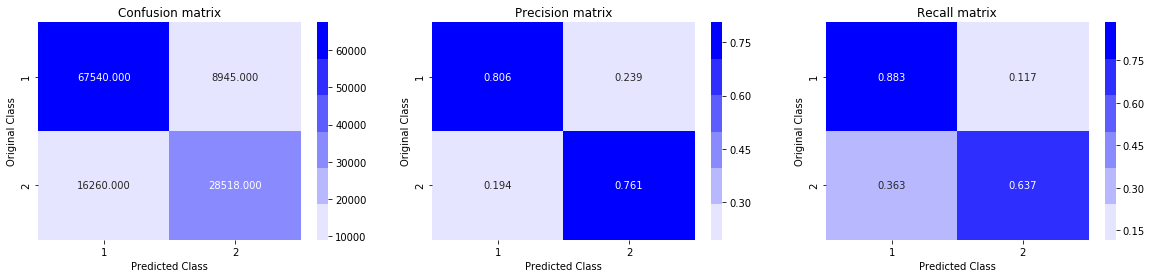

In [37]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 2.3 XGBOOST </h2>

In [58]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.68492	valid-logloss:0.68492
[10]	train-logloss:0.61602	valid-logloss:0.61608
[20]	train-logloss:0.56437	valid-logloss:0.56450
[30]	train-logloss:0.52568	valid-logloss:0.52577
[40]	train-logloss:0.49657	valid-logloss:0.49676
[50]	train-logloss:0.47346	valid-logloss:0.47377
[60]	train-logloss:0.45502	valid-logloss:0.45539
[70]	train-logloss:0.44014	valid-logloss:0.44053
[80]	train-logloss:0.42820	valid-logloss:0.42862
[90]	train-logloss:0.41834	valid-logloss:0.41874
[100]	train-logloss:0.41036	valid-logloss:0.41076
[110]	train-logloss:0.40377	valid-logloss:0.40417
[120]	train-logloss:0.39829	valid-logloss:0.39871
[130]	train-logloss:0.39379	valid-logloss:0.39424
[140]	train-logloss:0.38986	valid-logloss:0.39038
[150]	train-logloss:0.38662	valid-logloss:0.38719
[160]	train-logloss:0.38378	valid-logloss:0.38438
[170]	train-logloss:0.38116	valid-logloss:0.38183
[180]	train-logloss:0.37888	valid-logloss:0.37959
[190]	train-logloss:0.37690	valid-logloss:0.37764
[200]	train

<h2>2 Computing Average weighted TFIDF word2Vec and combining both Data sets </h2>

In [3]:
# Creating Word2Vec dictionary from Pre-training model Glove
import time
glove = open(r'Z:\DS DATA\glove.6B.300d.txt',encoding="utf8")
start_time =time.clock()
glovedict={}
for line in glove:
    l=line.split()
    glovedict[l[0]] =np.array(l[1:],dtype="float64")
print(time.clock()-start_time,"seconds")        

19.008379699999978 seconds


In [6]:
# Initilizing TFIDF VECTORIZEER FOR QUESTION 1 AND QUESTION 2
Tfidf_Vect_question1 = TfidfVectorizer()
Tfidf_Vect_question2 = TfidfVectorizer()


# Creating features of question
Tfidf_q1 = Tfidf_Vect_question1.fit_transform(df["question1"].values.astype("U")) 
Tfidf_q2 = Tfidf_Vect_question2.fit_transform(df["question2"].values.astype("U")) 

In [7]:
start_clock = time.clock()
tfidf_dict_q1 = dict(zip(Tfidf_Vect_question1.get_feature_names(),Tfidf_Vect_question1.idf_))
tfidf_dict_q2 = dict(zip(Tfidf_Vect_question2.get_feature_names(),Tfidf_Vect_question2.idf_))
print(time.clock()-start_clock)

13.509074399999918


In [61]:
import time
s_t = time.clock()
df_start = pd.read_csv(r"Z:\DS DATA\feature_train.csv")[:20001]
# df_start.dropna(axis=0,inplace=True)
print(time.clock()-s_t,"seconds")


3.9097409000005428 seconds


In [28]:
df_start.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19999 entries, 0 to 20000
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                19999 non-null  int64  
 1   qid1              19999 non-null  int64  
 2   qid2              19999 non-null  int64  
 3   question1         19999 non-null  object 
 4   question2         19999 non-null  object 
 5   is_duplicate      19999 non-null  int64  
 6   freq_qid1         19999 non-null  int64  
 7   freq_qid2         19999 non-null  int64  
 8   q1_total_words    19999 non-null  int64  
 9   q2_total_words    19999 non-null  int64  
 10  q1_n_words        19999 non-null  int64  
 11  q2_n_words        19999 non-null  int64  
 12  q1_union_q2       19999 non-null  int64  
 13  q1_q2_word_share  19999 non-null  int64  
 14  total_words       19999 non-null  int64  
 15  word_share        19999 non-null  float64
 16  intr_by_union     19999 non-null  float6

In [23]:
df1 = pd.DataFrame()

In [29]:
def Computing_Weight_tfidf_q1(x):
    weight_vector=np.zeros((300)) #creating empty vector for summing  
    que=x.split()
    sum_tfidf=0 # creating empty to sum tfidf value
    
    for i in que:
        glove_dim = glovedict.get(i,0) # Fetching the Glove vector representation of word
        tfidf_value = tfidf_dict_q1.get(i,0) # Fetching the Glove vector representation of word
        if type(glove_dim)!=int and type(tfidf_value)!=int:
            glove_dim = glove_dim * tfidf_value # multiplying glove vector with tfidf value
            weight_vector += glove_dim #summing each words dimentional with previous word dim.
                                            #to create a single 300 vector
            sum_tfidf+=tfidf_value # suming tfidf value 
            
    return list(weight_vector/sum_tfidf)


7.450000020980951e-05 seconds


In [15]:
def Computing_Weight_tfidf_q2(x):
    weight_vector=np.zeros((300)) #creating empty vector for summing  
    que=x.split()
    sum_tfidf=0 # creating empty to sum tfidf value
    
    for i in que:
        glove_dim = glovedict.get(i,0) # Fetching the Glove vector representation of word
        tfidf_value = tfidf_dict_q2.get(i,0) # Fetching the Glove vector representation of word
        if type(glove_dim)!=int and type(tfidf_value)!=int:
            glove_dim = glove_dim * tfidf_value # multiplying glove vector with tfidf value
            weight_vector += glove_dim #summing each words dimentional with previous word dim.
                                            #to create a single 300 vector
            sum_tfidf+=tfidf_value # suming tfidf value 
            
    return list(weight_vector/sum_tfidf)

In [30]:
start_clock = time.clock()
df1['Q1'] =df_start['question1'].apply(Computing_Weight_tfidf_q1)
print(time.clock()-start_clock,"seconds")

19.216298999999708 seconds


In [31]:
start_clock = time.clock()
df1["Q2"] =df_start['question2'].apply(Computing_Weight_tfidf)
print(time.clock()-start_clock,"seconds")

7.599503199999617 seconds


In [40]:
st_clk = time.clock()

df_q1 = pd.DataFrame(df1.Q1.values.tolist(),index = df1.index)
df_q2 = pd.DataFrame(df1.Q2.values.tolist(),index = df1.index)

# concatination of data frames
# final_data = pd.concat([df_start,df_q1,df_d2],axis=1)
print(time.clock()-st_clk,"seconds")

2.1787829999993846 seconds


In [56]:
df_start.drop(columns=["id","qid1","qid2","question1","question2"],inplace=True)
final_data = pd.concat([df_start,df_q1,df_q2],axis=1)
final_data.dropna(axis=0,inplace=True)
Target = final_data["is_duplicate"]
final_data.drop(columns=["is_duplicate"],inplace=True)


In [57]:
print(final_data.shape,Target.shape)

(10000, 627) (10000,)


In [58]:
X_train,X_test, y_train, y_test = train_test_split(
    final_data, Target, stratify=Target, test_size=0.3)

In [59]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

print("-"*15,"Distribution of points y_train","-"*15)
print("Class 0: {}%        Class 1: {}%".format(
    y_train.value_counts()[0]/len(y_train),y_train.value_counts()[1]/len(y_train)))
print("-"*15,"Distribution of points y_test","-"*15)
print("Class 0: {}%        Class 1: {}%".format(
    y_test.value_counts()[0]/len(y_test),y_test.value_counts()[1]/len(y_test)))


Number of data points in train data : (7000, 627)
Number of data points in test data : (3000, 627)
--------------- Distribution of points y_train ---------------
Class 0: 0.6288571428571429%        Class 1: 0.37114285714285716%
--------------- Distribution of points y_test ---------------
Class 0: 0.629%        Class 1: 0.371%


<h2> 1.1 Logistic Regression with hyperparameter tuning on Word2vec. Data set </h2>

For values of alpha =  1e-05 The log loss is: 0.4225261933461168
For values of alpha =  0.0001 The log loss is: 0.422751800794475
For values of alpha =  0.001 The log loss is: 0.43509963912888316
For values of alpha =  0.01 The log loss is: 0.4274534081523422
For values of alpha =  0.1 The log loss is: 0.4441951878203008
For values of alpha =  1 The log loss is: 0.48778560471932464
For values of alpha =  10 The log loss is: 0.535572365816426


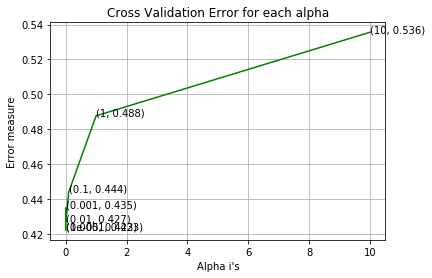

For values of best alpha =  1e-05 The train log loss is: 0.4057668178153224
For values of best alpha =  1e-05 The test log loss is: 0.4225261933461168
Total number of data points : 3000


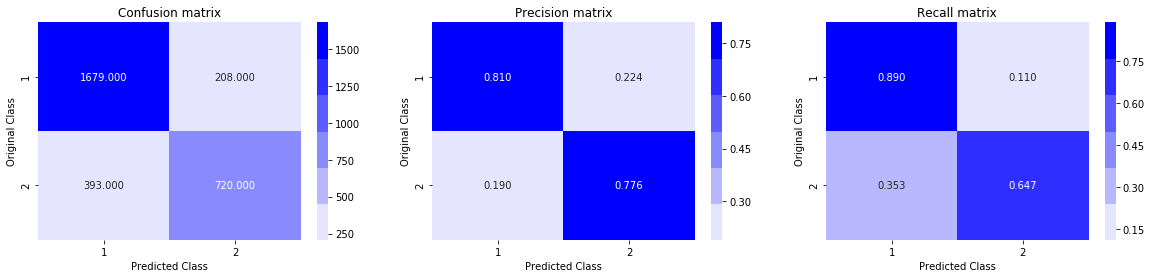

In [60]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [ ]:
# print(len(y_test))
# print(len(pred_y))
# C = confusion_matrix(y_test,predicted_y)
# # print(classification_report(y_test,pred_y))

# # pd.DataFrame(cm,columns=sorted(yy.unique()),index=sorted(yy.unique()))
# print(C)



# A =(((C.T)/(C.sum(axis=1))).T)
# B =(C/C.sum(axis=0))
# plt.figure(figsize=(20,4))
    
# labels = [1,2]
# # representing A in heatmap format
# cmap=sns.light_palette("blue")
# plt.subplot(1, 3, 1)
# sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
# plt.xlabel('Predicted Class')
# plt.ylabel('Original Class')
# plt.title("Confusion matrix")

# plt.subplot(1, 3, 2)
# sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
# plt.xlabel('Predicted Class')
# plt.ylabel('Original Class')
# plt.title("Precision matrix")

# plt.subplot(1, 3, 3)
# # representing B in heatmap format
# sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
# plt.xlabel('Predicted Class')
# plt.ylabel('Original Class')
# plt.title("Recall matrix")

# plt.show()

# print(classification_report(y_test,predicted_y))
# pd.DataFrame(cm,columns=sorted(y_test.unique()),index=sorted(y_test.unique()))